In [1]:
library(tidyverse)
library(ggplot2)
library(data.table)
library(patchwork)
library(ggnewscale)
library(scales)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘packag

In [2]:
annot_map = read_tsv("results/simulated_data/sweeps/annot_overlap_ensembl_havana_104_exons_chr1_100.tsv")

Rows: 100 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): chr, annot
dbl (3): sim_left, sim_right, overlap

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
rec_map = read_tsv("results/simulated_data/sweeps/rec_map_chr1_100.tsv", col_names=c("sim_left", "sim_right", "cum_cM", "cM"))
rec_map$chrom = "chr1"

Rows: 100 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (4): sim_left, sim_right, cum_cM, cM

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
ptm <- proc.time()
all_df = fread("results/simulated_data/sweeps/all_sims.stats.tsv")
proc.time() - ptm


   user  system elapsed 
  2.164   0.525   8.037 

In [5]:
head(all_df)

model,demo,seed,chrom,sim_left,sim_right,annot,dfe,coeff,tmult,pop,stat_left,stat_right,stat_name,stat_val
<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<int>,<int>,<chr>,<dbl>
neutral,OutOfAfrica_3G09,1501552846,chr1,55550,5055550,,,NA,NA,YRI,55550,555550,div,0.00081753
neutral,OutOfAfrica_3G09,1501552846,chr1,55550,5055550,,,NA,NA,CEU,55550,555550,div,0.00057988
neutral,OutOfAfrica_3G09,1501552846,chr1,55550,5055550,,,NA,NA,YRI,555550,1055550,div,0.00089517
neutral,OutOfAfrica_3G09,1501552846,chr1,55550,5055550,,,NA,NA,CEU,555550,1055550,div,0.00073359
neutral,OutOfAfrica_3G09,1501552846,chr1,55550,5055550,,,NA,NA,YRI,1055550,1555550,div,0.00083922
neutral,OutOfAfrica_3G09,1501552846,chr1,55550,5055550,,,NA,NA,CEU,1055550,1555550,div,0.00064164


In [6]:
unique(all_df$stat_name)

[1] "div" "clr"

In [7]:
df = all_df
df[df$stat_name=="div",]$stat_val = max(df[df$stat_name=="div",]$stat_val, na.rm=T)-df[df$stat_name=="div",]$stat_val
df$sw_loc = (df$sim_left + df$sim_right)/2
df = left_join(df, rec_map)
df[df$cM < 0.001,]$stat_val = NA

Joining with `by = join_by(chrom, sim_left, sim_right)`


In [8]:
table(df$model)


    bgs neutral   sweep 
1240000 1240000 2480000 

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


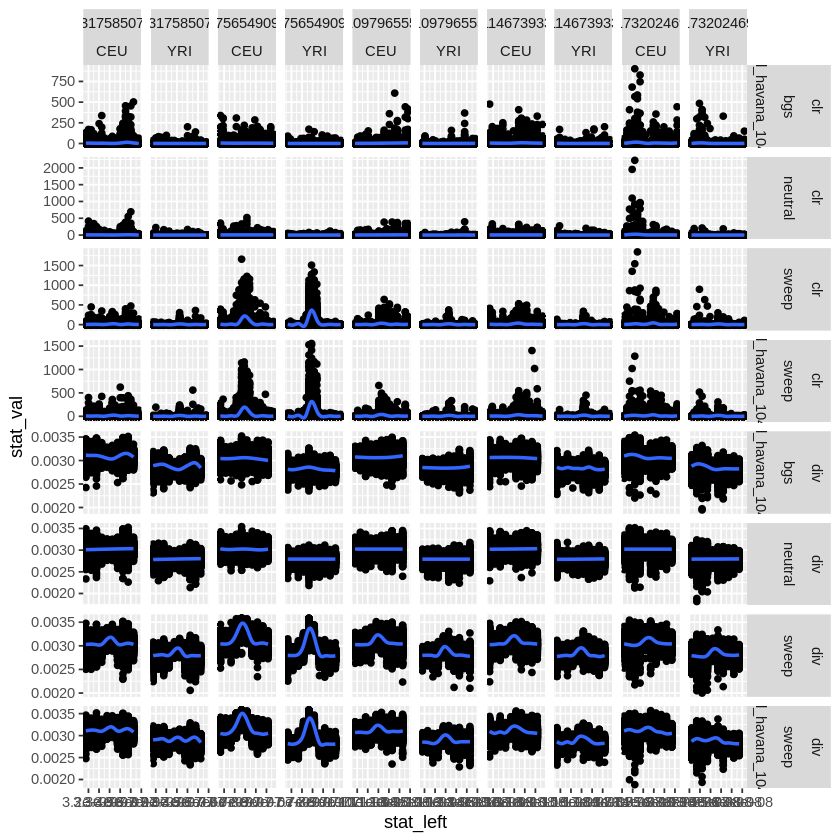

In [9]:
ggplot(df[df$sim_left %in% sample(unique(df[!is.na(df$stat_val),]$sim_left), 5),], aes(x=stat_left, y=stat_val)) + geom_point()+ 
    facet_grid(stat_name+model+annot~sim_left+pop, scales="free") + geom_smooth()

In [10]:
df_sub = df %>%
    group_by(pop,model,demo,chrom,sim_left,annot,dfe,coeff,tmult,seed,stat_name) %>%
    filter(stat_val == max(stat_val) | is.na(stat_val)) %>%
    arrange(pop,model,annot,dfe,coeff,tmult) %>% filter(row_number()==1)

In [11]:
df %>%
    group_by(pop,model,demo,chrom,sim_left,annot,dfe,coeff,tmult, stat_name) %>%
    filter(stat_val == max(stat_val)) %>%
    group_by(stat_name,pop,model,demo,chrom,annot,dfe,coeff,tmult) %>%
    summarize(maxmean = mean(stat_val, na.rm=TRUE))

`summarise()` has grouped output by 'stat_name', 'pop', 'model', 'demo',
'chrom', 'annot', 'dfe', 'coeff'. You can override using the `.groups`
argument.


stat_name,pop,model,demo,chrom,annot,dfe,coeff,tmult,maxmean
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
clr,CEU,bgs,OutOfAfrica_3G09,chr1,ensembl_havana_104_exons,Gamma_H17,NA,NA,1.579107e+04
clr,CEU,neutral,OutOfAfrica_3G09,chr1,,,NA,NA,8.248888e+02
clr,CEU,sweep,OutOfAfrica_3G09,chr1,,,0.03,1,1.427940e+04
clr,CEU,sweep,OutOfAfrica_3G09,chr1,ensembl_havana_104_exons,Gamma_H17,0.03,1,2.205134e+04
clr,YRI,bgs,OutOfAfrica_3G09,chr1,ensembl_havana_104_exons,Gamma_H17,NA,NA,1.796822e+04
clr,YRI,neutral,OutOfAfrica_3G09,chr1,,,NA,NA,1.495703e+03
clr,YRI,sweep,OutOfAfrica_3G09,chr1,,,0.03,1,2.406789e+04
clr,YRI,sweep,OutOfAfrica_3G09,chr1,ensembl_havana_104_exons,Gamma_H17,0.03,1,2.561541e+04
div,CEU,bgs,OutOfAfrica_3G09,chr1,ensembl_havana_104_exons,Gamma_H17,NA,NA,3.473952e-03


In [12]:
global_neut_q5s = df_sub[df_sub$model == "neutral" & df_sub$cM > 0.001,] %>% group_by(pop, stat_name) %>% summarize(neut_q5 = quantile(stat_val, c(0.95), na.rm=T))
global_bgs_q5s = df_sub[df_sub$model == "bgs" & df_sub$cM > 0.001,] %>% group_by(pop, stat_name) %>% summarize(bgs_q5 = quantile(stat_val, c(0.95), na.rm=T))
df_sub = left_join(df_sub, global_neut_q5s)
df_sub = left_join(df_sub, global_bgs_q5s)
global_neut_q5s
global_bgs_q5s

`summarise()` has grouped output by 'pop'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'pop'. You can override using the `.groups`
argument.
Joining with `by = join_by(pop, stat_name)`
Joining with `by = join_by(pop, stat_name)`


pop,stat_name,neut_q5
<chr>,<chr>,<dbl>
CEU,clr,2.054610e+02
CEU,div,3.373797e-03
YRI,clr,5.865305e+01
YRI,div,3.086321e-03


pop,stat_name,bgs_q5
<chr>,<chr>,<dbl>
CEU,clr,2.543670e+02
CEU,div,3.411303e-03
YRI,clr,7.913200e+01
YRI,div,3.155641e-03


`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 6400 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 6400 rows containing missing values (`geom_point()`).”


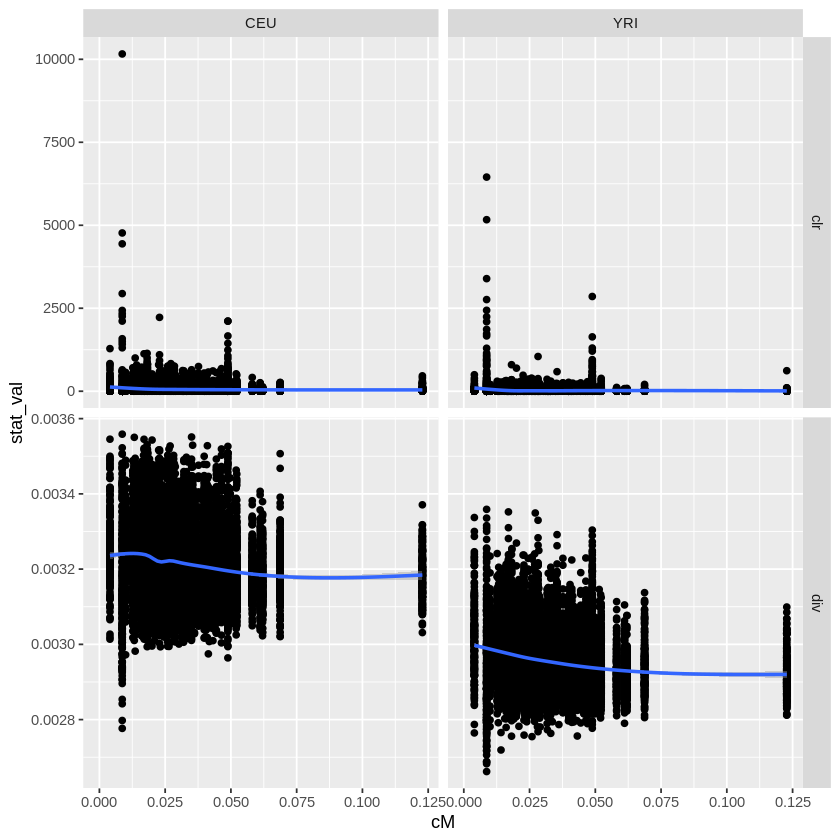

In [13]:
ggplot(df_sub[df_sub$model == "neutral",], aes(x = cM, y=stat_val)) + geom_point() + facet_grid(stat_name~pop, scale="free")+ geom_smooth()

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 6400 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 6400 rows containing missing values (`geom_point()`).”


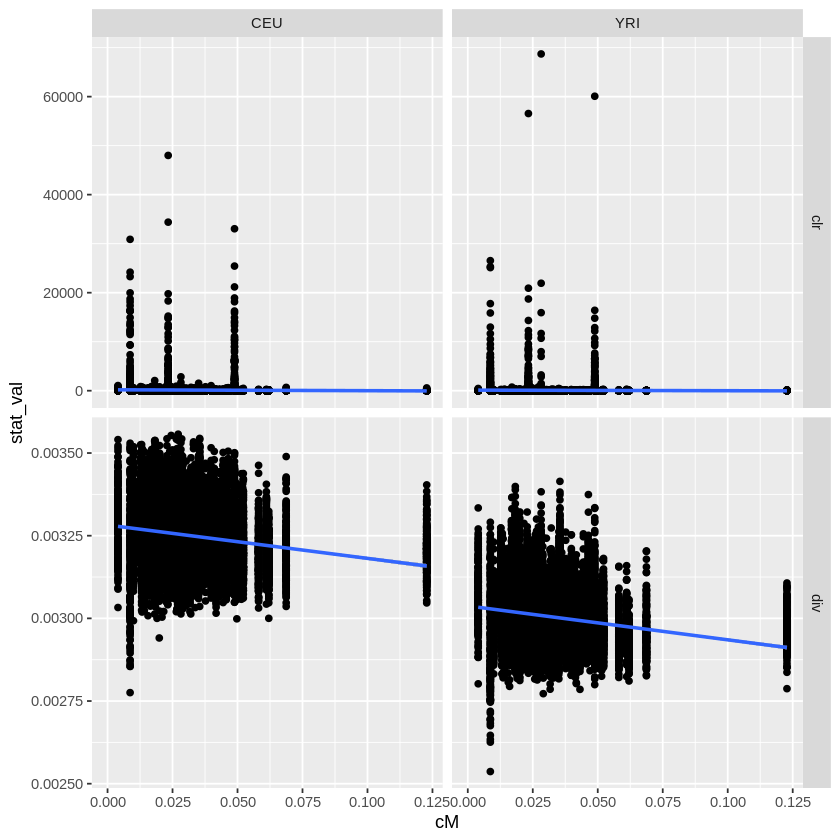

In [14]:
ggplot(df_sub[df_sub$model == "bgs",], aes(x = cM, y=stat_val)) + geom_point() + facet_grid(stat_name~pop, scale="free")+ geom_smooth(method="lm")

In [15]:
#df_sub %>% arrange(model, sim_left, pop)

In [16]:
#df_sub[df_sub$model == "neutral",] %>% group_by(sim_left, pop) %>% summarize(q5 = quantile(stat_val, c(0.05), na.rm=T), num=n())

In [17]:
df_sub$neut_is_neg = df_sub$stat_val < df_sub$neut_q5
df_sub$bgs_is_neg = df_sub$stat_val < df_sub$bgs_q5

In [18]:
sub_summary = df_sub %>% group_by(stat_name,sim_left, model, annot, pop, coeff) %>% summarise(neut_num_neg = sum(neut_is_neg),bgs_num_neg = sum(bgs_is_neg), total=n())
sub_summary$neut_nr = sub_summary$neut_num_neg / sub_summary$total
sub_summary$neut_pr = 1-sub_summary$neut_nr
sub_summary$bgs_nr = sub_summary$bgs_num_neg / sub_summary$total
sub_summary$bgs_pr = 1-sub_summary$bgs_nr
sub_summary = left_join(sub_summary, rec_map)
sub_summary = left_join(sub_summary, annot_map)

`summarise()` has grouped output by 'stat_name', 'sim_left', 'model', 'annot',
'pop'. You can override using the `.groups` argument.
Joining with `by = join_by(sim_left)`
Joining with `by = join_by(sim_left, annot, sim_right)`


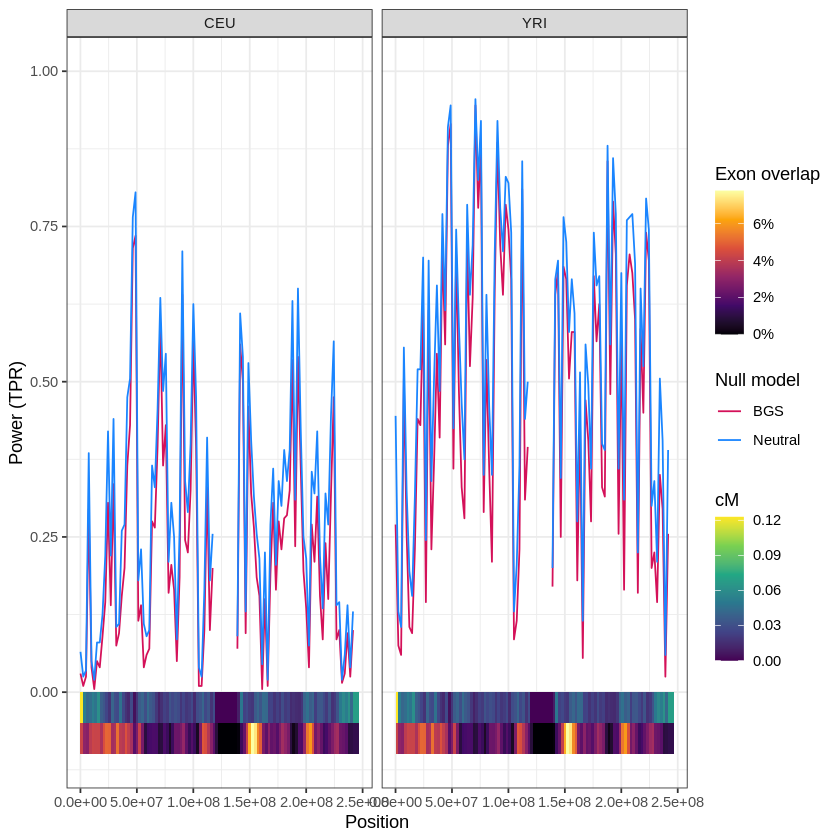

In [19]:
p1_df = sub_summary[sub_summary$model=="sweep" & sub_summary$annot!="",]
p1_df =  p1_df %>%
    filter(stat_name=="clr") %>%
    select(stat_name:coeff, neut_pr, bgs_pr, sim_right, cM, chrom, overlap) %>%
    pivot_longer(neut_pr:bgs_pr, names_pattern="(.*)_pr")
colpal = c('#D41159','#1A85FF')
p1_df$name[p1_df$name=="neut"] = "Neutral"
p1_df$name[p1_df$name=="bgs"] = "BGS"
p1 = ggplot(p1_df, aes(y=value, x=sim_left)) + 
    geom_line(aes(col=name)) + facet_grid(.~pop) +
    geom_rect(aes(xmin=sim_left, xmax=sim_right, ymin=-.05, ymax=0.00, fill=cM))+
    scale_fill_viridis_c(option="D") +
    new_scale_fill() +
    geom_rect(aes(xmin=sim_left, xmax=sim_right, ymin=-.1, ymax=-.05, fill=overlap))+
    scale_fill_viridis_c(option="B", labels=label_percent()) +
    labs(x="Position", y="Power (TPR)", col="Null model", fill="Exon overlap") +
    theme_bw() + ylim(-0.1,1) + scale_colour_manual(values =colpal)
ggsave("results/simulated_data/sweeps/chr1_power.pdf", width=11, height=6.5)
p1

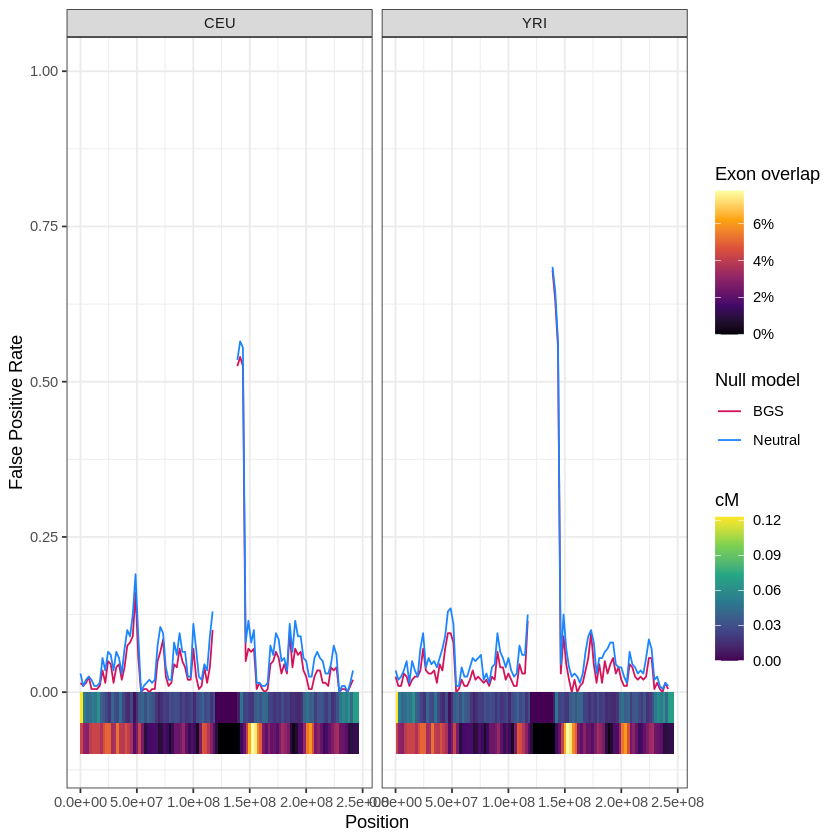

In [20]:
p2_df = sub_summary[sub_summary$model=="bgs" & sub_summary$annot!="",]
p2_df =  p2_df %>%
    filter(stat_name=="clr") %>%
    select(stat_name:coeff, neut_pr, bgs_pr, sim_right, cM, chrom, overlap) %>%
    pivot_longer(neut_pr:bgs_pr, names_pattern="(.*)_pr")
p2_df$name[p2_df$name=="neut"] = "Neutral"
p2_df$name[p2_df$name=="bgs"] = "BGS"
p2 = ggplot(p2_df, aes(y=value, x=sim_left)) + 
    geom_line(aes(col=name)) + facet_grid(.~pop) +
    geom_rect(aes(xmin=sim_left, xmax=sim_right, ymin=-.05, ymax=0.00, fill=cM))+
    scale_fill_viridis_c(option="D") +
    new_scale_fill() +
    geom_rect(aes(xmin=sim_left, xmax=sim_right, ymin=-.1, ymax=-.05, fill=overlap))+
    scale_fill_viridis_c(option="B", labels=label_percent()) +
    labs(x="Position", y="False Positive Rate", col="Null model", fill="Exon overlap") +
    theme_bw() + ylim(-0.1,1.) + scale_colour_manual(values =colpal)
ggsave("results/simulated_data/sweeps/chr1_fpr.pdf", width=11, height=6.5)
p2

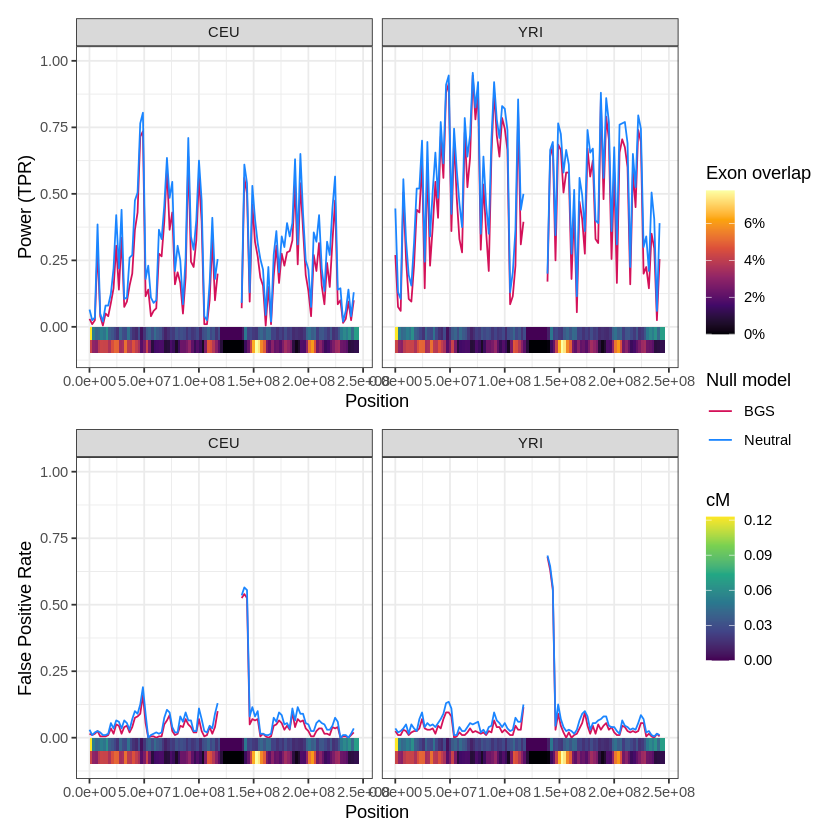

In [21]:
p1 / p2 + plot_layout(guides="collect")
ggsave("results/simulated_data/sweeps/chr1_power_and_fpr.pdf", width=11, height=8)

In [24]:
with(sub_summary[sub_summary$model=="sweep" & sub_summary$stat_name=="div",], plot(cM, pr))

ERROR: Error in eval(substitute(expr), data, enclos = parent.frame()): object 'pr' not found


In [ ]:
with(sub_summary[sub_summary$model=="sweep" & sub_summary$stat_name=="clr" & sub_summary$annot!="",], plot(cM, bgs_pr))

In [ ]:
with(sub_summary[sub_summary$model=="sweep" & sub_summary$stat_name=="clr" & sub_summary$annot!="",], plot(cM, neut_pr))

In [ ]:
sub_summary[sub_summary$model=="sweep" & sub_summary$stat_name=="clr" & sub_summary$annot!="",]

In [ ]:
sub_summary[sub_summary$model=="neutral",]

In [ ]:
length(unique(all_df[all_df$model=="neutral",]$seed))

In [ ]:
length(unique(all_df[all_df$model=="bgs",]$seed))


In [ ]:
length(unique(df[df$model=="sweep",]$seed))
